#### Merging two codes

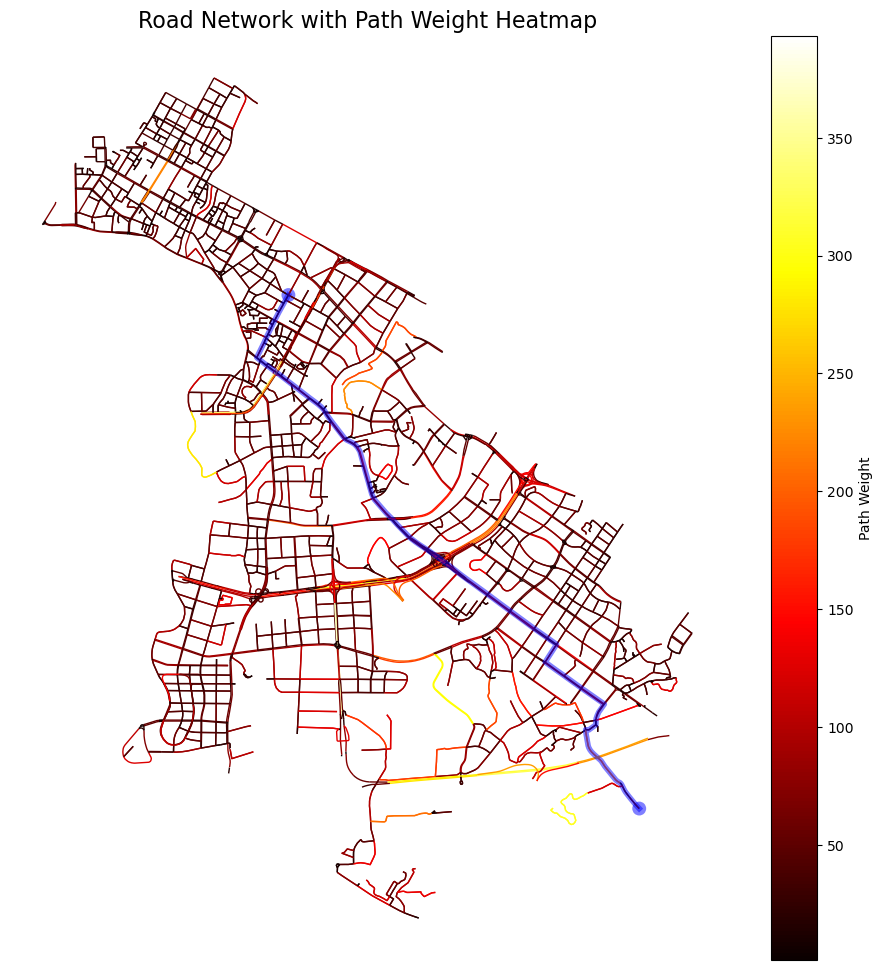

In [25]:
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point

# ---------------------------
# 1. Load Road Network and Define Area
# ---------------------------

# Define the area of interest
place_name = "Jinjiang District, Chengdu, China"

# Load the driving network for the defined area
G = ox.graph_from_place(place_name, network_type='drive')

# Project the graph for accurate distance calculations and plotting
G_proj = ox.project_graph(G)

# ---------------------------
# 2. Assign Risk Scores to Edges
# ---------------------------

# Convert the graph to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G_proj)

# Initialize random risk scores for each edge
np.random.seed(42)  # For reproducibility
edges_gdf['risk_score'] = np.random.rand(len(edges_gdf))

# Map risk scores back to the graph edges
edges_gdf = edges_gdf.reset_index()
risk_score_dict = edges_gdf.set_index(['u', 'v', 'key'])['risk_score'].to_dict()
for u, v, key, data in G_proj.edges(keys=True, data=True):
    data['risk_score'] = risk_score_dict.get((u, v, key), 0)

# ---------------------------
# 3. Compute Path Weights
# ---------------------------

# Define risk coefficient to balance distance and risk
risk_coeff = 0.8  # Adjust between 0 and 1

# Compute combined weight for each edge
max_risk = edges_gdf['risk_score'].max()
for u, v, data in G_proj.edges(data=True):
    # Normalize risk score
    if max_risk > 0:
        normalized_risk = data['risk_score'] / max_risk
    else:
        normalized_risk = 0
    # Compute path weight
    data['path_weight'] = risk_coeff * normalized_risk + (1 - risk_coeff) * data.get('length', 1)

# Update edges_gdf with path_weight
path_weight_dict = {(u, v, key): data['path_weight'] for u, v, key, data in G_proj.edges(keys=True, data=True)}
edges_gdf['path_weight'] = edges_gdf.apply(lambda row: path_weight_dict.get((row['u'], row['v'], row['key']), 0), axis=1)

# ---------------------------
# 4. Plot Heatmap Based on Path Weights
# ---------------------------

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the edges with colors based on path_weight
edges_gdf.plot(
    ax=ax,
    column='path_weight',
    cmap='hot',
    linewidth=1,
    legend=True,
    norm=colors.Normalize(vmin=edges_gdf['path_weight'].min(), vmax=edges_gdf['path_weight'].max()),
    legend_kwds={'label': "Path Weight", 'orientation': "vertical"}
)

# Remove axis
ax.set_axis_off()

# Add title
ax.set_title('Road Network with Path Weight Heatmap', fontsize=16)

# ---------------------------
# 5. Compute and Plot the Safest Route
# ---------------------------

# Define origin and destination points (ensure they're within the graph area)
# Define origin and destination points (ensure they're within the graph area)
orig_point = (0.627478, 120.075541)  # Replace with actual coordinates
dest_point = (30.640000, 104.100000)  # Replace with actual coordinates

# Create Shapely Points from the latitude and longitude
orig_point_geom = Point(orig_point[1], orig_point[0])  # (lon, lat)
dest_point_geom = Point(dest_point[1], dest_point[0])  # (lon, lat)

# Create GeoDataFrames with the correct CRS
orig_point_gdf = gpd.GeoDataFrame(geometry=[orig_point_geom], crs='EPSG:4326')
dest_point_gdf = gpd.GeoDataFrame(geometry=[dest_point_geom], crs='EPSG:4326')

# Project the points to the graph's CRS
orig_point_proj = orig_point_gdf.to_crs(G_proj.graph['crs']).geometry.values[0]
dest_point_proj = dest_point_gdf.to_crs(G_proj.graph['crs']).geometry.values[0]

# Find the nearest network nodes
orig_node = ox.nearest_nodes(G_proj, orig_point_proj.x, orig_point_proj.y)
dest_node = ox.nearest_nodes(G_proj, dest_point_proj.x, dest_point_proj.y)

# Compute the safest path
if orig_node != dest_node:
    safest_route = nx.shortest_path(G_proj, orig_node, dest_node, weight='path_weight')
else:
    print("Origin and destination nodes are the same; please choose different coordinates.")

# Plot the safest route
ox.plot_graph_route(
    G_proj,
    safest_route,
    ax=ax,
    route_color='blue',
    route_linewidth=,
    orig_dest_node_size=100,
    orig_dest_node_color='green',
    show=False,
    close=False
)


plt.show()
